Fase 1: Preprocessing
Dimensioni: Train=179, Validation=60, Test=60

Fase 2: Riduzione della dimensionalità con PCA
Numero di componenti per spiegare il 95% della varianza: k = 8


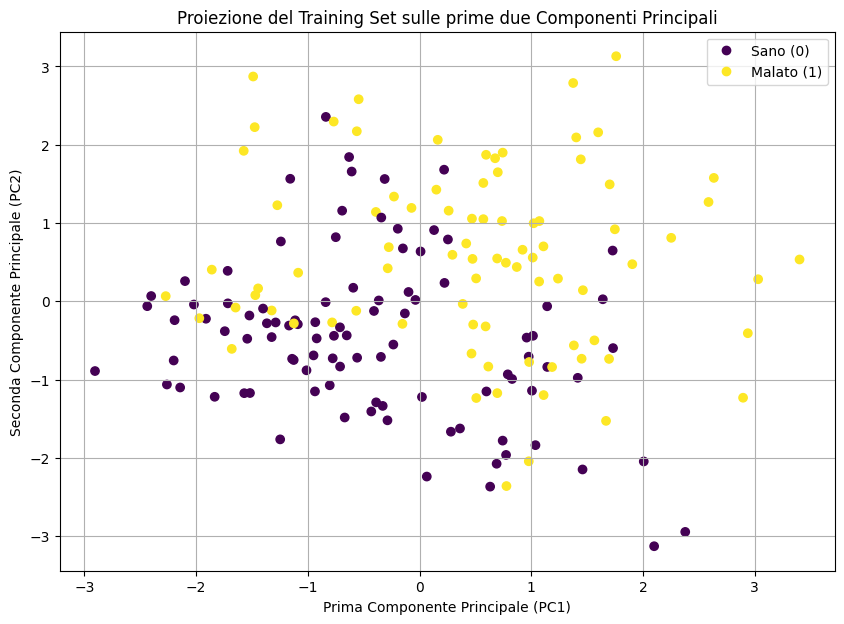


Fase 3: Regressione
Risultati sul Validation Set:
             Modello  MSE_Validation
1             Ridge      302.622922
0  LinearRegression      306.460755
2      RandomForest      326.478054
3               SVR      346.420856

Modello di Regressione Selezionato: Ridge
MSE su Test Set: 383.9117
MAE su Test Set: 14.4211

 Fase 4: Classificazione


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Tabella di Confronto
         Modello  Accuracy  Precision    Recall  F1-score
0  Rete Neurale  0.616667   0.580645  0.642857  0.610169


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    classification_report
)


FILE_PATH = '/kaggle/input/heart-disease-data/heart_disease_uci.csv' 
TEST_SIZE = 0.2 
VAL_SIZE = 0.2
RANDOM_STATE = 42 


def load_and_preprocess_data(file_path): 
    print("Fase 1: Preprocessing")
    df = pd.read_csv(file_path) 

    df = df.dropna() 
    
    cols_to_drop = [c for c in ['cp', 'restecg', 'slope', 'thal', 'ca'] if c in df.columns] 
    df = df.drop(columns=cols_to_drop) 
    
    y_class = (df['num'] > 0).astype(int) 
    y_reg = df['thalch'].copy() 

    X = df.drop(columns=['thalch', 'num', 'dataset']) 

    
    for col in ['sex', 'fbs', 'exang']: 
        if col in X.columns: 
            X[col] = X[col].astype('category').cat.codes 

    X_train_full, X_test, y_train_class, y_test_class, y_train_reg, y_test_reg = train_test_split( 
        X, y_class, y_reg, test_size=TEST_SIZE, stratify=y_class, random_state=RANDOM_STATE 
    )
    
    val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE) 

    X_train, X_val, y_train_class, y_val_class, y_train_reg, y_val_reg = train_test_split( 
        X_train_full, y_train_class, y_train_reg, test_size=val_size_adjusted, stratify=y_train_class, random_state=RANDOM_STATE
    )

    print(f"Dimensioni: Train={X_train.shape[0]}, Validation={X_val.shape[0]}, Test={X_test.shape[0]}") 

    scaler = StandardScaler().fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_val_std = scaler.transform(X_val)
    X_test_std = scaler.transform(X_test)
    
    data_splits = { 
        'X_train_std': X_train_std, 'X_val_std': X_val_std, 'X_test_std': X_test_std,
        'y_train_class': y_train_class, 'y_val_class': y_val_class, 'y_test_class': y_test_class,
        'y_train_reg': y_train_reg, 'y_val_reg': y_val_reg, 'y_test_reg': y_test_reg
    }
    
    return data_splits, X.columns 

def perform_pca_analysis(data_splits): 
    print("\nFase 2: Riduzione della dimensionalità con PCA")
    X_train_std = data_splits['X_train_std'] 
    

    pca_95 = PCA(n_components=0.95, svd_solver='full', random_state=RANDOM_STATE).fit(X_train_std) 
    k = pca_95.n_components_ 
    print(f"Numero di componenti per spiegare il 95% della varianza: k = {k}")
    
    
    X_train_pca = pca_95.transform(X_train_std)
    X_val_pca = pca_95.transform(data_splits['X_val_std'])
    X_test_pca = pca_95.transform(data_splits['X_test_std'])

    
    pca_2d = PCA(n_components=2, random_state=RANDOM_STATE).fit(X_train_std)
    X_train_2d = pca_2d.transform(X_train_std) 

   
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=data_splits['y_train_class']) 
    plt.title('Proiezione del Training Set sulle prime due Componenti Principali')
    plt.xlabel('Prima Componente Principale (PC1)')
    plt.ylabel('Seconda Componente Principale (PC2)')
    plt.legend(labels=['Sano (0)', 'Malato (1)'])
    plt.grid(True)
    plt.show()


    data_splits.update({ 
        'X_train_pca': X_train_pca,
        'X_val_pca': X_val_pca,
        'X_test_pca': X_test_pca,
    })
    return data_splits 


def evaluate_regression_models(data_splits):
    print("\nFase 3: Regressione")

    X_train_pca = data_splits['X_train_pca']
    y_train_reg = data_splits['y_train_reg']
    X_val_pca = data_splits['X_val_pca']
    y_val_reg = data_splits['y_val_reg']
    X_test_pca = data_splits['X_test_pca']
    y_test_reg = data_splits['y_test_reg']

   
    models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(random_state=RANDOM_STATE),
        'RandomForest': RandomForestRegressor(random_state=RANDOM_STATE),
    }

    param_grids = {
        'LinearRegression': {},
        'Ridge': {'alpha': [0.1, 1.0, 10.0, 100.0]},
        'RandomForest': {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]},
    }

    best_models = {}
    val_results = []
    
    for name, model in models.items(): 
        if param_grids[name]: 
            gs = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', cv=5) 
            gs.fit(X_train_pca, y_train_reg) 
            best_model = gs.best_estimator_ 
        else: 
            best_model = model.fit(X_train_pca, y_train_reg)
        
        best_models[name] = best_model 
        y_val_pred = best_model.predict(X_val_pca) 
        mse_val = mean_squared_error(y_val_reg, y_val_pred) 
        val_results.append({'Modello': name, 'MSE_Validation': mse_val}) 

    df_val_results = pd.DataFrame(val_results).sort_values('MSE_Validation') 
    print("Risultati sul Validation Set:\n", df_val_results)
    
    selected_name = df_val_results['Modello'].values[0] 
    selected_model = best_models[selected_name] 
    
    y_test_pred = selected_model.predict(X_test_pca) 
    mse_test = mean_squared_error(y_test_reg, y_test_pred)
    mae_test = mean_absolute_error(y_test_reg, y_test_pred)

    print(f"\nModello di Regressione Selezionato: {selected_name}")
    print(f"MSE su Test Set: {mse_test:.4f}")
    print(f"MAE su Test Set: {mae_test:.4f}")


def evaluate_classification_models(data_splits):
    print("\n Fase 4: Classificazione")
    
    
    X_train_pca, y_train_class = data_splits['X_train_pca'], data_splits['y_train_class']
    X_val_pca, y_val_class = data_splits['X_val_pca'], data_splits['y_val_class']
    X_test_pca, y_test_class = data_splits['X_test_pca'], data_splits['y_test_class']
    
   
    param_nn = {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [1e-3, 1e-2]} 
    best_nn = None 
    best_recall_nn = -1 

    for params in ParameterGrid(param_nn): 
        model = MLPClassifier(random_state=RANDOM_STATE, max_iter=1000) 
        model.fit(X_train_pca, y_train_class) 
        y_val_pred = model.predict(X_val_pca) 
        current_recall = recall_score(y_val_class, y_val_pred, pos_label=1)  
        if current_recall > best_recall_nn:
            best_recall_nn = current_recall
            best_nn = model

    models = {'Rete Neurale': best_nn} 
    
    val_rows = [] 
    for name, model in models.items():
        y_val_pred = model.predict(X_val_pca) 
        val_rows.append({  
            'Modello': name,
            'Accuracy': accuracy_score(y_val_class, y_val_pred),
            'Precision': precision_score(y_val_class, y_val_pred, pos_label=1),
            'Recall': recall_score(y_val_class, y_val_pred, pos_label=1),
            'F1-score': f1_score(y_val_class, y_val_pred, pos_label=1)
        })

if __name__ == "__main__": 
    data_splits, feature_names = load_and_preprocess_data(FILE_PATH) 
    data_splits_pca = perform_pca_analysis(data_splits) 
    evaluate_regression_models(data_splits_pca) 
    evaluate_classification_models(data_splits_pca) 